In [279]:
import pandas as pd
import numpy as np
import re
from scipy import stats
from matplotlib import pyplot as plt

In [280]:
# Loading the data from files

# More detailed documentation can be found here
#        https://mimic.mit.edu/docs/iii/tables/
# For simplicity, we are only loading 
#        admissions - data from admission of a patient, links to patients on subject_id
#        patients   - data defining a patient
df_admissions = pd.read_csv('data/ADMISSIONS.csv')
df_patients = pd.read_csv('data/PATIENTS.csv')

#column names to lowercase
df_admissions.columns = df_admissions.columns.str.lower()
df_patients.columns = df_patients.columns.str.lower()

#print(df_admissions.shape)
#print(df_patients.shape)

In [281]:
# Processing the ADMISSIONS table

df_admissions = df_admissions.drop(columns=['hadm_id', 'admittime', 'dischtime', 'deathtime',
                                            'admission_type', 'admission_location', 'discharge_location', 
                                            'diagnosis', 'has_chartevents_data'])

# Sorting (ascending, so missing values are last), to minimize data loss
# we keep the first row with subject_id and demographic info
df_demographics = (
    df_admissions
    .drop(columns=['edregtime', 'edouttime', 'hospital_expire_flag'])
    .sort_values(by=['subject_id','insurance','language','religion','marital_status','ethnicity'])
    .groupby('subject_id')
    .first()
    .reset_index()
    .drop(columns=['row_id'])
)

# These few columns need to be sorted in descending order to keep 
# the last hospital visit per subject_id
df_times_sorted = (
    df_admissions
    .loc[:, ['subject_id','edregtime','edouttime','hospital_expire_flag']] 
    .sort_values(by=['subject_id','edregtime','edouttime','hospital_expire_flag'], ascending=False)
    .groupby('subject_id')
    .first()
    .reset_index()
)

#Merge the demographics and times df
df_admi = pd.merge(df_demographics, df_times_sorted, on="subject_id")

#count number of hospital admissions per patient (subject_id)
admission_count = (
    df_admissions
    .groupby('subject_id')
    .count()
    .reset_index()
    .rename(columns={"row_id": "adm_count"})
    .loc[:, ['subject_id', 'adm_count']] 
)

#Merge the admissions count into the df
df_admissions = pd.merge(df_admi, admission_count, on="subject_id")
#print(df_demographics.head(25))

In [282]:
# Processing the PATIENTS table

#print(admin_count)
df_patients = df_patients.drop(columns=['row_id', 'dod_ssn'])

#merge condensed admissions with the patients df
df = pd.merge(df_admissions, df_patients, on="subject_id") 

In [283]:

print("Admissions:\n",df_admissions.count(),"\n")
print("Patients:\n", df_patients.count(),"\n")
print("Merged:\n", df.count())

Admissions:
 subject_id              46520
insurance               46520
language                25209
religion                46086
marital_status          36757
ethnicity               46520
edregtime               23956
edouttime               23956
hospital_expire_flag    46520
adm_count               46520
dtype: int64 

Patients:
 subject_id     46520
gender         46520
dob            46520
dod            15759
dod_hosp        9974
expire_flag    46520
dtype: int64 

Merged:
 subject_id              46520
insurance               46520
language                25209
religion                46086
marital_status          36757
ethnicity               46520
edregtime               23956
edouttime               23956
hospital_expire_flag    46520
adm_count               46520
gender                  46520
dob                     46520
dod                     15759
dod_hosp                 9974
expire_flag             46520
dtype: int64


In [284]:
#df.subject_id.isna()
#len(df.subject_id.unique())
print(len(df))
df.head()
#df.describe()

46520


,subject_id,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag,adm_count,gender,dob,dod,dod_hosp,expire_flag
0,2,Private,None,NOT SPECIFIED,None,ASIAN,None,None,0,1,M,2138-07-17 00:00:00,NaN,NaN,0
1,3,Medicare,None,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,0,1,M,2025-04-11 00:00:00,2102-06-14 00:00:00,NaN,1
2,4,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,0,1,F,2143-05-12 00:00:00,NaN,NaN,0
3,5,Private,None,BUDDHIST,None,ASIAN,None,None,0,1,M,2103-02-02 00:00:00,NaN,NaN,0
4,6,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,None,None,0,1,F,2109-06-21 00:00:00,NaN,NaN,0


In [287]:
#data cleanup and grouping

df['ethnicity'] = list(map(lambda s: re.sub("UNKNOWN.*|UNABLE.*|PATIENT.*", "OTHER", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("WHITE.*|PORTUGUESE.*", "WHITE", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("ASIAN.*", "ASIAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("BLACK.*", "BLACK", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("HISPANIC.*|AMERICAN.*", "AMERICAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("CARIBBEAN.*|HAWAIIAN.*", "AMERICAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub(".*AMERICAN", "AMERICAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("MULTI.*", "MULTI RACE", s), df['ethnicity']))

df['marital_status'] = df['marital_status'].fillna('UNKNOWN')
df['marital_status'] = list(map(lambda s: re.sub("UNKNOWN.*", "UNKNOWN", s), df['marital_status']))

df['religion'] = df['religion'].fillna('UNKNOWN')
df['religion'] = list(map(lambda s: re.sub("NOT.*|UN.*|OTHER", "UNKNOWN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub("PROT.*|LUTH.*|METHO.*|BAPT.*", "CHRISTIAN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub(".*ORTH.*|.*ADVEN.*|CHRIST.*", "CHRISTIAN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub("EPISCO.*|CATHOLIC|JEHOV.*", "CHRISTIAN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub("HEBREW", "JEWISH", s), df['religion']))

df['language'] = df['language'].fillna('UNKNOWN')
df['language'] = list(map(lambda s: re.sub("\*.*", "OTHER", s), df['language']))
lan_counts = df['language'].value_counts() > 700
df['language'] = list(map(lambda s: s if lan_counts[s] else "OTHER", df['language']))

#print(df['language'].value_counts())
#print(df['language'].unique())


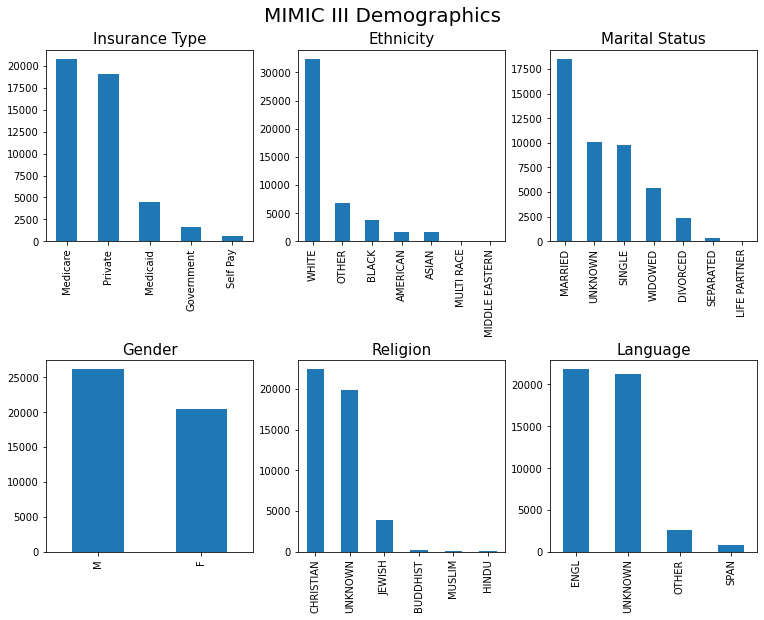

In [288]:
fig = plt.figure(layout='constrained')
plt.rcParams["figure.figsize"] = (10.5, 8.5)
fig.suptitle('MIMIC III Demographics', fontsize=20)
ax1 = fig.add_subplot(2,3,1)
ax1 = df['insurance'].value_counts().plot(kind='bar')
ax1.set_title('Insurance Type', fontsize = 15)
ax2 = fig.add_subplot(2,3,2)
ax2 = df['ethnicity'].value_counts().plot(kind='bar')
ax2.set_title('Ethnicity', fontsize = 15)
ax3 = fig.add_subplot(2,3,3)
ax3 = df['marital_status'].value_counts().plot(kind='bar')
ax3.set_title('Marital Status', fontsize = 15)
ax4 = fig.add_subplot(2,3,4)
ax4 = df['gender'].value_counts().plot(kind='bar')
ax4.set_title('Gender', fontsize = 15)
ax5 = fig.add_subplot(2,3,5)
ax5 = df['religion'].value_counts().plot(kind='bar')
ax5.set_title('Religion', fontsize = 15)
ax5 = fig.add_subplot(2,3,6)
ax5 = df['language'].value_counts().plot(kind='bar')
ax5.set_title('Language', fontsize = 15)
plt.show()

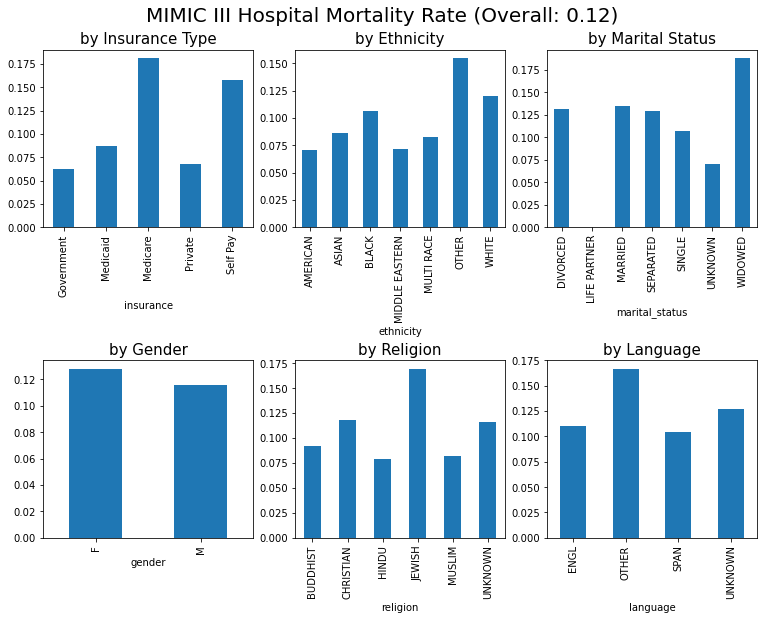

In [298]:
#calculate overall mortality rate
mort_rate = df.hospital_expire_flag.mean()

fig = plt.figure(layout='constrained')
fig.suptitle('MIMIC III Hospital Mortality Rate (Overall: '+str(round(mort_rate,2))+')', fontsize=20)
plt.rcParams["figure.figsize"] = (10.5, 8.5)
ax1 = fig.add_subplot(2,3,1)
ax1 = df.groupby('insurance').hospital_expire_flag.mean().plot(kind='bar')
ax1.set_title('by Insurance Type', fontsize = 15)
ax2 = fig.add_subplot(2,3,2)
ax2 = df.groupby('ethnicity').hospital_expire_flag.mean().plot(kind='bar')
ax2.set_title('by Ethnicity', fontsize = 15)
ax3 = fig.add_subplot(2,3,3)
ax3 = df.groupby('marital_status').hospital_expire_flag.mean().plot(kind='bar')
ax3.set_title('by Marital Status', fontsize = 15)
ax4 = fig.add_subplot(2,3,4)
ax4 = df.groupby('gender').hospital_expire_flag.mean().plot(kind='bar')
ax4.set_title('by Gender', fontsize = 15)
ax5 = fig.add_subplot(2,3,5)
ax5 = df.groupby('religion').hospital_expire_flag.mean().plot(kind='bar')
ax5.set_title('by Religion', fontsize = 15)
ax5 = fig.add_subplot(2,3,6)
ax5 = df.groupby('language').hospital_expire_flag.mean().plot(kind='bar')
ax5.set_title('by Language', fontsize = 15)
plt.show()

In [273]:
#group.size()

#The following code prints out the data that is plotted above
group = df.groupby('insurance')
print(group.hospital_expire_flag.mean())

group = df.groupby('ethnicity')
print(group.hospital_expire_flag.mean())

group = df.groupby('marital_status')
print(group.hospital_expire_flag.mean())

group = df.groupby('gender')
print(group.hospital_expire_flag.mean())

group = df.groupby('religion')
print(group.hospital_expire_flag.mean())

group = df.groupby('language')
print(group.hospital_expire_flag.mean())


insurance
Government    0.061958
Medicaid      0.087374
Medicare      0.181041
Private       0.067506
Self Pay      0.157324
Name: hospital_expire_flag, dtype: float64
ethnicity
AMERICAN          0.070930
ASIAN             0.086391
BLACK             0.105998
MIDDLE EASTERN    0.071429
MULTI RACE        0.082569
OTHER             0.154716
WHITE             0.120557
Name: hospital_expire_flag, dtype: float64
marital_status
DIVORCED        0.131635
LIFE PARTNER    0.000000
MARRIED         0.134877
SEPARATED       0.129630
SINGLE          0.107440
UNKNOWN         0.070216
WIDOWED         0.187995
Name: hospital_expire_flag, dtype: float64
gender
F    0.128045
M    0.115654
Name: hospital_expire_flag, dtype: float64
religion
BUDDHIST     0.091837
CHRISTIAN    0.117600
HINDU        0.079208
JEWISH       0.169390
MUSLIM       0.082278
UNKNOWN      0.116446
Name: hospital_expire_flag, dtype: float64
language
ENGL       0.110311
OTHER      0.166731
SPAN       0.104010
UNKNOWN    0.127164
Name: 

In [ ]:

#look at length of stay - admissions table (edouttime - edregtime)
#look at length of stay - ICUSTAYS table has los field, join by subject_id
#num of admissions - admissions table
#num of procedures - procedures_icd table
#num of prescriptions - prescriptions table
#numof tests - microbiology events table
#number of procedures, tests, drugs

#compare avg los, proceduces, etc per group, do anova f_oneway
#stats.f_oneway(sepal_len_setosa, sepal_len_vers, sepal_len_virg)

#look at correlation matrix for final dataframe
#correlation matrix
#correlation_matrix = df.corr(method='pearson')
#sns.heatmap(correlation_matrix, vmax=1.0, vmin=-1.0,square=True, cmap='viridis')
#correlation_matrix

In [ ]:
#look at diagnosis for categories - the documentation said that one should not 
# try to stratify data on this field, so didn't do this

# Future work would include:
#look at age groups - do if more time
#long term mortality - do if more time
#      create new plot for long term mortalities, different for different groups?
# look at 50s, white male. How many are alive long term? Is it less?